# Remote EIS measurement with file transfer

This example shows, when Thales and the Python remote control are executed on different computers, how to transfer the measurement files.

The measurement data is automatically exchanged with the [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html#thales-file-interface) class via TCP/IP.

<img src="https://doc.zahner.de/github_resources/thales_python.png" alt="Thales Python Setup" style="width: 800px;"/>

In [13]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import (
    PotentiostatMode,
    ScanStrategy,
    ScanDirection,
    FileNaming,
    Pad4Mode,
    ThalesRemoteScriptWrapper,
)
from thales_remote.file_interface import ThalesFileInterface
from zahner_analysis.file_import.ism_import import IsmImport

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter
import os
import shutil

# Connect Python to the already launched Thales-Software

The variable **remoteIP** contains the IP address of the computer on which the Thales software is running and to which the ZENNIUM is connected via USB. This variable is passed to the two constructors for connection establishment via the interface classes.

In [14]:
if __name__ == "__main__":
    remoteIP = "192.168.2.66"

    zenniumConnection = ThalesRemoteConnection()
    zenniumConnection.connectToTerm(remoteIP, "ScriptRemote")

    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()

    zahnerZennium.calibrateOffsets()

devel version


# Establish the connection for the transfer of measurement files

With the class [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html#thales-file-interface) a connection to the Term/Thales software via network is established. It provides the methods to control the file transfer.


In [15]:
fileInterface = ThalesFileInterface(remoteIP)

# Perform an impedance measurement

For this example, an impedance measurement is parameterized to show the transfer of the measurement data after the measurement. This is explained in detail in other examples.

It is important here that the naming of the files is set to **individual**, then the ism file is named with "myeis", without number or time stamp. The path specified is the local path on the computer who runs Thales.

In [16]:
zahnerZennium.setEISOutputPath(r"C:\THALES\temp")
zahnerZennium.setEISNaming(FileNaming.INDIVIDUAL)
zahnerZennium.setEISOutputFileName("myeis")

zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
zahnerZennium.setAmplitude(100e-3)
zahnerZennium.setPotential(0)
zahnerZennium.setLowerFrequencyLimit(10)
zahnerZennium.setStartFrequency(1000)
zahnerZennium.setUpperFrequencyLimit(10000)
zahnerZennium.setLowerNumberOfPeriods(5)
zahnerZennium.setLowerStepsPerDecade(5)
zahnerZennium.setUpperNumberOfPeriods(20)
zahnerZennium.setUpperStepsPerDecade(5)
zahnerZennium.setScanDirection(ScanDirection.START_TO_MAX)
zahnerZennium.setScanStrategy(ScanStrategy.SINGLE_SINE)

zahnerZennium.enablePotentiostat()

zahnerZennium.measureEIS()

zahnerZennium.disablePotentiostat()
zahnerZennium.setAmplitude(0)

'OK\r'

# Obtaining a single measurement file

After the measurement, the measurement file can be retrieved from the remote computer using [acquireFile](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.acquireFile).

To transfer the file we need to pass as parameter the path of the file on the computer on which Thales is running. The file path is composed of the path and filename specified in the previous.

In [17]:
file = fileInterface.acquireFile(r"C:\THALES\temp\myeis.ism")

The file is returned as a dictionary. This dictionary contains the following keys:

**Key** |**Content** |**Example**
-----|-----|----- 
"name"|Filename |"myeis.ism"
"path"|Filepath |"C:\THALES\temp\myeis.ism"
"binary_data"|Binary file content |Type: bytearray()

As an example, the file is written to the disk with appropriate Python functions.

In [18]:
fileHandle = open(r"C:\THALES\temp\manual_save.ism", "wb")
fileHandle.write(file.binaryData)
fileHandle.close()

The binary file content as bytearray(), of the dictionary key "binary_data" can be passed to the [IsmImport](https://doc.zahner.de/zahner_analysis/file_import/#zahner_analysis.file_import.ism_import.IsmImport) class for further processing. Then the measurement data can be processed directly with Python, for example to plot the data with matplotlib.

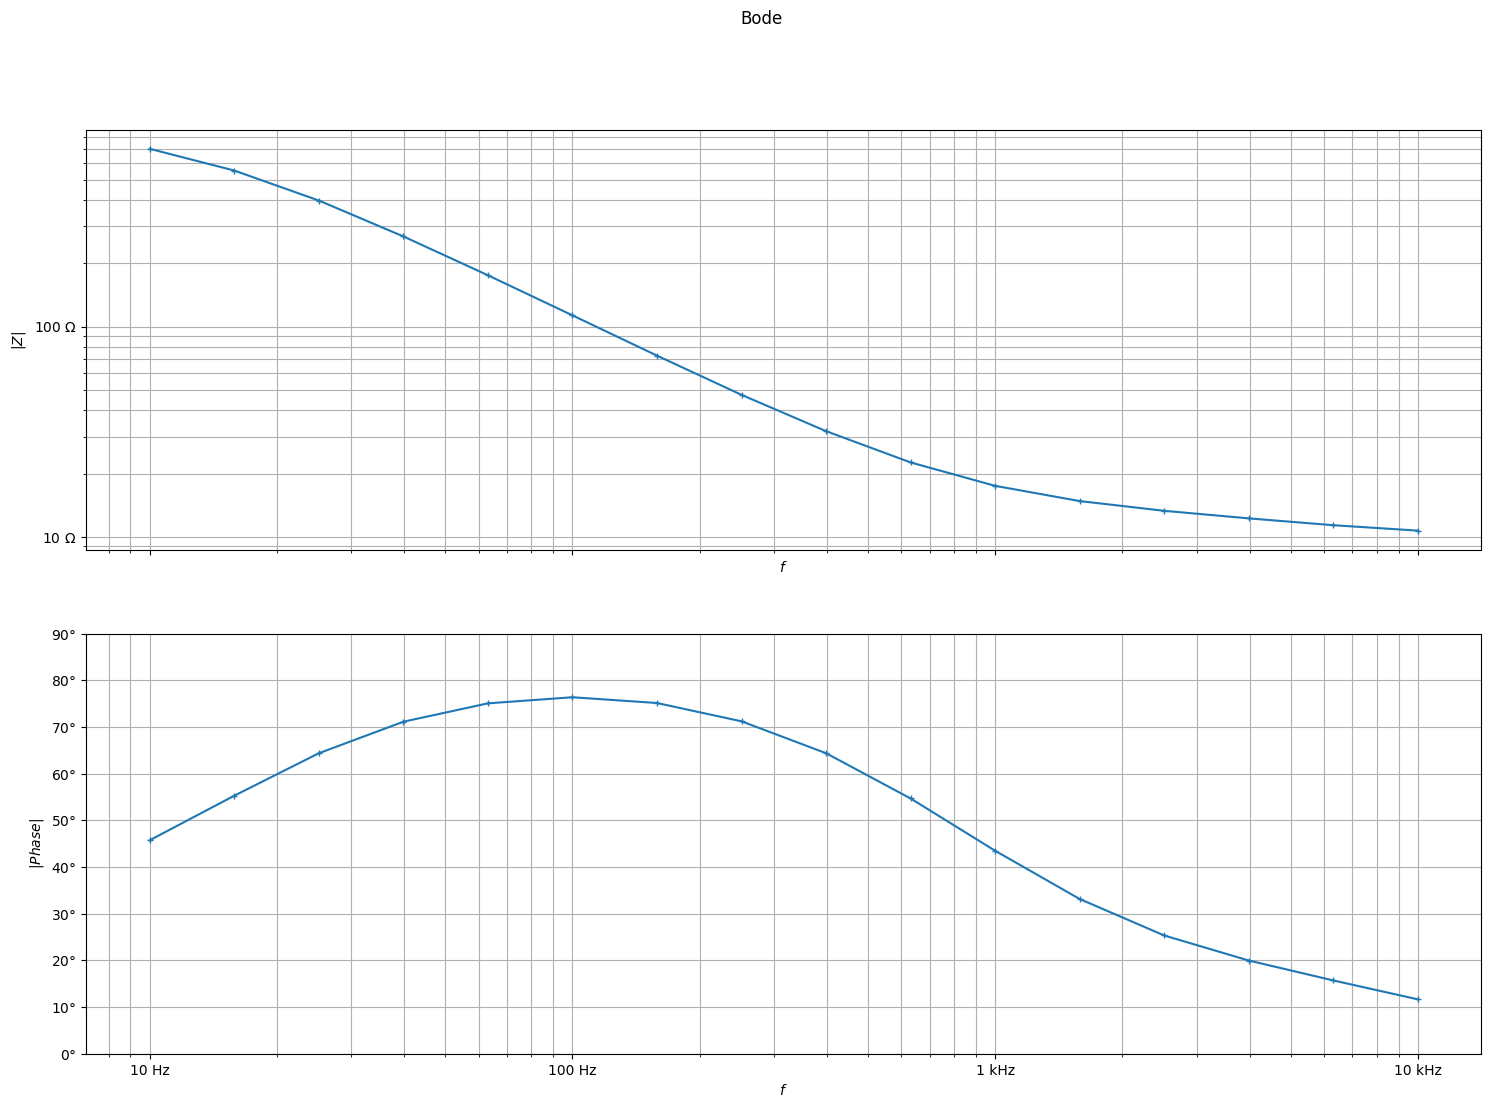

In [19]:
ismFile = IsmImport(file.binaryData)

impedanceFrequencies = ismFile.getFrequencyArray()

impedanceAbsolute = ismFile.getImpedanceArray()
impedancePhase = ismFile.getPhaseArray()

figBode, (impedanceAxis, phaseAxis) = plt.subplots(2, 1, sharex=True)
figBode.suptitle("Bode")

impedanceAxis.loglog(impedanceFrequencies, impedanceAbsolute, marker="+", markersize=5)
impedanceAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
impedanceAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
impedanceAxis.set_xlabel(r"$f$")
impedanceAxis.set_ylabel(r"$|Z|$")
impedanceAxis.grid(which="both")

phaseAxis.semilogx(
    impedanceFrequencies,
    np.abs(impedancePhase * (360 / (2 * np.pi))),
    marker="+",
    markersize=5,
)
phaseAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
phaseAxis.yaxis.set_major_formatter(EngFormatter(unit="$°$", sep=""))
phaseAxis.set_xlabel(r"$f$")
phaseAxis.set_ylabel(r"$|Phase|$")
phaseAxis.grid(which="both")
phaseAxis.set_ylim([0, 90])
figBode.set_size_inches(18, 12)
plt.show()

# Obtain all measurement files automatically

Instead of calling up each measurement file individually, it is possible to switch on the automatic transfer of all files this is explained below.

For the example, the contents of the local directory are first deleted to show what has been received after the measurement. **The user does not need this section.**

In [20]:
localDirectory = r"C:\THALES\temp\test"

# Delete the entire contents of the directory.
for file in os.listdir(localDirectory):
    fileWithPath = os.path.join(localDirectory, file)
    try:
        if os.path.isfile(fileWithPath) or os.path.islink(fileWithPath):
            os.unlink(fileWithPath)
        elif os.path.isdir(fileWithPath):
            shutil.rmtree(fileWithPath)
    except:
        pass

## Configuration 

With [enableSaveReceivedFilesToDisk](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.enableSaveReceivedFilesToDisk) it is configured that the received files should be saved locally. With the parameter path the path is passed, at which the files are to be stored on the local computer.

The method [enableKeepReceivedFilesInObject](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.enableKeepReceivedFilesInObject), which activates that the measurement data are stored in the Python object, would not be necessary, because this is the default state. If you make a lot of measurements and you don't need them in Python anymore you can disable this with [disableKeepReceivedFilesInObject](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.disableKeepReceivedFilesInObject).

With [enableAutomaticFileExchange](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.enableAutomaticFileExchange) the automatic transfer is activated. The default parameter *fileExtensions="\*.ism\*.isc\*.isw"* of the method [enableAutomaticFileExchange](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.enableAutomaticFileExchange) specifies that ism, isc and isw files should be transferred automatically, these are the results of EIS, CV and IE.

In [21]:
fileInterface.enableSaveReceivedFilesToDisk(path=localDirectory)
fileInterface.enableKeepReceivedFilesInObject()
fileInterface.enableAutomaticFileExchange()

'128,FileExchange,ON'

Now the measurement is reconfigured so that the measurements are numbered starting with 13 and the [PAD4](https://zahner.de/products/addon-cards/pad4.html) card is used. For PAD4 measurements the automatic file transfer is also useful, because all PAD4 measurement files are transferred automatically.

The configuration of the PAD4 card is explained in another notebook.

In [22]:
zahnerZennium.setEISNaming("counter")
zahnerZennium.setEISCounter(13)
zahnerZennium.setEISOutputFileName("spectra")

zahnerZennium.setupPad4Channel(1, 1, 1, voltageRange=4.0, shuntResistor=10e-3)
zahnerZennium.setupPad4Channel(1, 2, 1, voltageRange=4.0, shuntResistor=10e-3)
zahnerZennium.setupPad4ModeGlobal(Pad4Mode.VOLTAGE)  # or Pad4Mode.CURRENT
zahnerZennium.enablePad4Global()

'OK\r'

## Perform the measurements

To show which files are transferred and how the process works, a spectrum is measured in the following, then automatic transfer is deactivated, a spectrum is measured again, and a third spectrum is measured when automatic transfer is activated.

In [23]:
zahnerZennium.measureEIS()
fileInterface.disableAutomaticFileExchange()

zahnerZennium.measureEIS()

fileInterface.enableAutomaticFileExchange()
zahnerZennium.measureEIS()
zahnerZennium.setAmplitude(0)

'OK\r'

## Further processing of the received data

The data can be read from the object with the method [getReceivedFiles](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface.getReceivedFiles). Then as an example the measurement end time of the respective file is read out here.

Since two PAD4 channels were active, additional measurement files are created for these channels. The filename is extended by a number depending on the impedance measurement and a additionally number for the PAD4 channels is added. The file with "_ser00" is the main channel.

In [24]:
for file in fileInterface.getReceivedFiles():
    ismFile = IsmImport(file.binaryData)
    print(f"{file.name} measurement finished at {ismFile.getMeasurementEndDateTime()}")

spectra_0013_ser00.ism measurement finished at 2023-08-08 09:48:56.148500
spectra_0013_ser01.ism measurement finished at 2023-08-08 09:48:56.148500
spectra_0013_ser02.ism measurement finished at 2023-08-08 09:48:56.148500
spectra_0015_ser00.ism measurement finished at 2023-08-08 09:50:43.787500
spectra_0015_ser01.ism measurement finished at 2023-08-08 09:50:43.787500
spectra_0015_ser02.ism measurement finished at 2023-08-08 09:50:43.787500


The output then shows which files were saved at the specified path.
Here the measurement with the number 14 is missing, because the automatic transfer was deactivated before the measurement.

In [25]:
for file in os.listdir(localDirectory):
    print(file)

spectra_0013_ser00.ism
spectra_0013_ser01.ism
spectra_0013_ser02.ism
spectra_0015_ser00.ism
spectra_0015_ser01.ism
spectra_0015_ser02.ism


# Close the connections

Finally, the two connections are disconnected.

In [26]:
zenniumConnection.disconnectFromTerm()
fileInterface.close()